In [2]:
!pip install vitaldb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 8.6 MB/s eta 0:00:00


In [1]:
##Initializing TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')


Tensorflow version 2.12.0
Running on TPU  ['10.34.69.18:8470']


In [1]:
##Importing the Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models, regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm
import vitaldb
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
"""
 Important!!!!!
 Note: my commentary will be in triple quotes to differentiate from the hashtag
 comments included in the original submission. 
 ----------------
 This last import does not appear to be used.
"""

"""
 Consider creating a config dictionary at the top to store all of our 
 parameters. This makes the code more modular. Easier to play with number
 of cases or downsampling strategy that way as well as cleaning up
 "magic numbers" that appear later.
"""


In [2]:
caseids = vitaldb.find_cases(['ECG_II','PLETH', 'ART'])
"""
 In the original documentation, we are requested to use ABP. There is another
 listing in vitalDB that explicitly has that label. The one we are using 
 appears to be SNUADC/ART with the same Tram-Rac 4A device as ECG_II and PLETH.
 Not saying this is wrong or needs to be changed, but it is worth checking with
 medical liason to see if it is more appropriate to use all readings from same
 device or if we should be using the one explicitly labeled ABP. Either way 
 this is an easy fix just change out the frame to 180 HZ from 500 HZ and change
 to ABP from ART *if* that is the case. 
"""

len(caseids)
"""
 This number is coming up as 3458. Important note later.
"""

3458

In [8]:
X = []
y = []
for i in tqdm(set([np.random.randint(0, 3644) for i in range(0,2)])):
    """
     Where was 3644 number coming from in the above line? The example on VitalDB
     uses this number, but we have a different number of cases see len(caseids).
     Why I tried the code, I randomly drew case 3600 which is out of range.
    """
    print(f"\nCase:{i}")
    vals = vitaldb.load_case(caseids[i], ['ECG_II','PLETH','ART'], 1/100)
    """
     The 1/100 parameter here stands out to me. Documentation indicates that
     this is the sample rate which for us should be 500Hz according to 
     vitalDB documentation.
    """
    try:
        ecg = vals[:,0]
        ppg = vals[:,1]
        art = vals[:,2]
        del vals
        na_indices = np.append(np.argwhere(np.isnan(ecg)),np.argwhere(np.isnan(ppg)), axis=0)
        na_indices = np.append(na_indices,np.argwhere(np.isnan(art)), axis=0)
        na_indices = np.unique(na_indices, axis=0)
        ecg=np.delete(ecg,na_indices)
        ppg=np.delete(ppg,na_indices)
        art=np.delete(art,na_indices)
        art_slide = np.mean(sliding_window_view(art, 2000)[::150000], axis=1)
        """
         In the documentation on vitalDB, we have 500HZ listed as our sampling rate for ART
         so 150000 samples between sampling windows would make sense. However, a 2000 sample
         reading window taking only the mean may leave out important data. BP is measured
         in systolic (max when the heart is pumping out blood in the cardiac cycle) and diastolic
         (min when the heart is pulling blood in as part of the cycle). An average of the entire 
         window would not capture this. Check with medical, but I think including the max
         and min of a sampling window may be more accurate to real-world conditions than
         taking just the mean - this min/max method appears to be what the original paper used.
         This is also one of the magic numbers I referenced earlier. 
         Including the downsampling strategy in the config file clears that up.
        """
        dup_art_windows = np.repeat(art_slide, 151999)[0:len(art)]
        del art_slide,na_indices
        if (len(ecg)==len(art)) & (len(ppg)==len(art)) & (len(ecg)==len(dup_art_windows)):
          X.append(np.array([ecg, ppg, dup_art_windows]))
          y.append(art)
          """
           Just like we deleted vals above, we can now include:
            # del ecg, ppg, art, dup_art_windows
           though if we do this, print(ecg ...) wil need to be deleted as well
          """
        #savemat(f"/data/user/nanabolu/all3signals/{i}.mat", {"mean_art":dup_art_windows, "abp":art, "ecg": ecg})
    except:
        pass


  0%|          | 0/2 [00:00<?, ?it/s]


Case:1331


 50%|█████     | 1/2 [00:07<00:07,  7.19s/it]


Case:1779


100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


In [9]:
print(len(ecg))
print(len(ppg))
print(len(art))
print(len(X))
"""
 It's generally a good idea to use f strings or to otherwise label checkpoints
 because they just pop up in the console without context. And we can delete or
 comment them out once we establish the data has the right shape.
"""

1430940
1430940
1430940
2


In [10]:
print(len(X[0][0]))
print(len(y[0]))


384419
384419


In [11]:
y[0]

array([-13.74699974, -14.7343998 , -13.74699974, ...,  -3.87240005,
        -4.85985994,  -3.87240005])

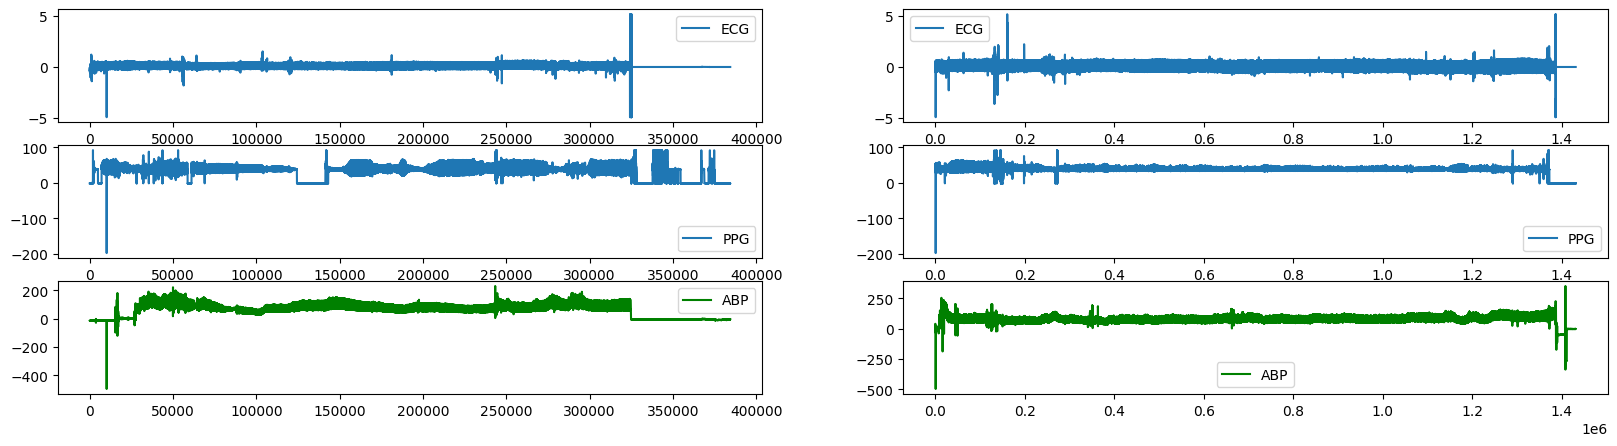

In [12]:
"""
 If we had a plotting function here, we could reuse that function rather than
 three blocks in a row. Consider labeling the figures so that the viewer has
 more information about what is being shown. As it is, the viewer has 8 graphs 
 with the label ECG and no other information. Also, consider separating or
 clearly demarking case 1 and case 2, maybe using the original caseids from
 vitaldb. Anything we can do to make the figs clearer to the viewer we should.
"""
# Plot the sequences when there are more than 1 samples
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 5))

for i in range(2):
    ax[0, i].plot(X[i][0], label='ECG')
    ax[0, i].legend()
    ax[1, i].plot(X[i][1], label='PPG')
    ax[1, i].legend()
    ax[2, i].plot(y[i].squeeze(), label='ABP',  color='green')
    ax[2, i].legend()

plt.show()
    """
    This appears to be plotting the entire dataset on one graph. Very difficult
    to read. The *zoomed in* view in the next figure is more user friendly in
    my opinion - though medical may be able to glean something from the
    macro view. Possibly identify areas of interest from the large peaks and valleys?
    Though if they are interested in large spikes or drops, we may be better off
    handling that in code via some max/min rather than graphically.
    """

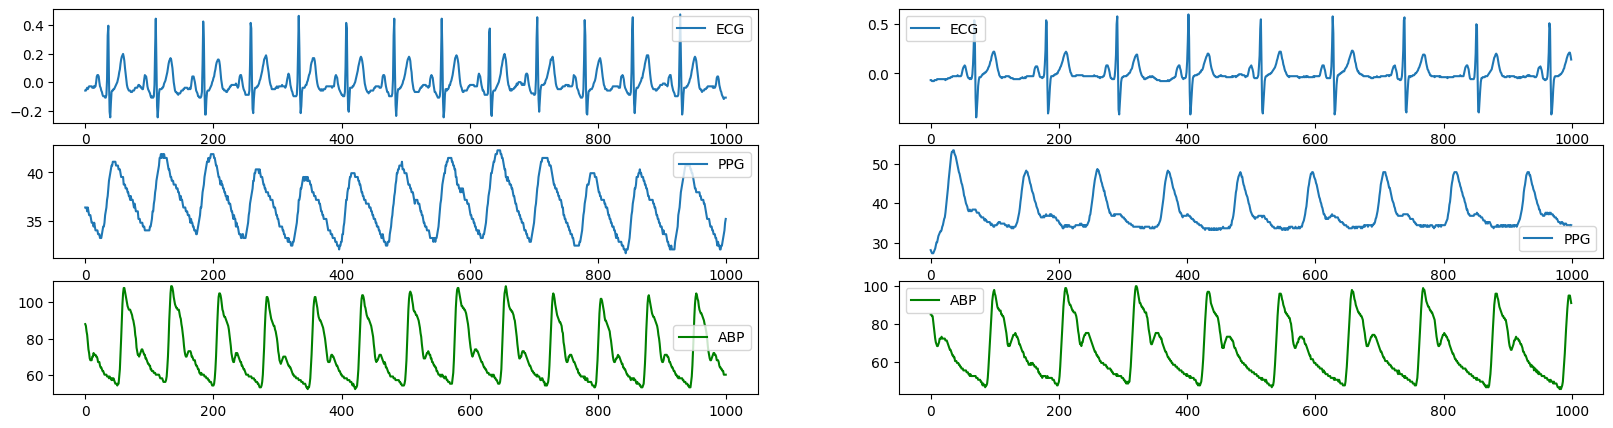

In [13]:
# Plot the sequences when there are more than 1 samples
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 5))

for i in range(2):
    ax[0, i].plot(X[i][0][200000:201000], label='ECG')
    ax[0, i].legend()
    ax[1, i].plot(X[i][1][200000:201000], label='PPG')
    ax[1, i].legend()
    ax[2, i].plot(y[i].squeeze()[200000:201000], label='ABP',  color='green')
    ax[2, i].legend()

plt.show()

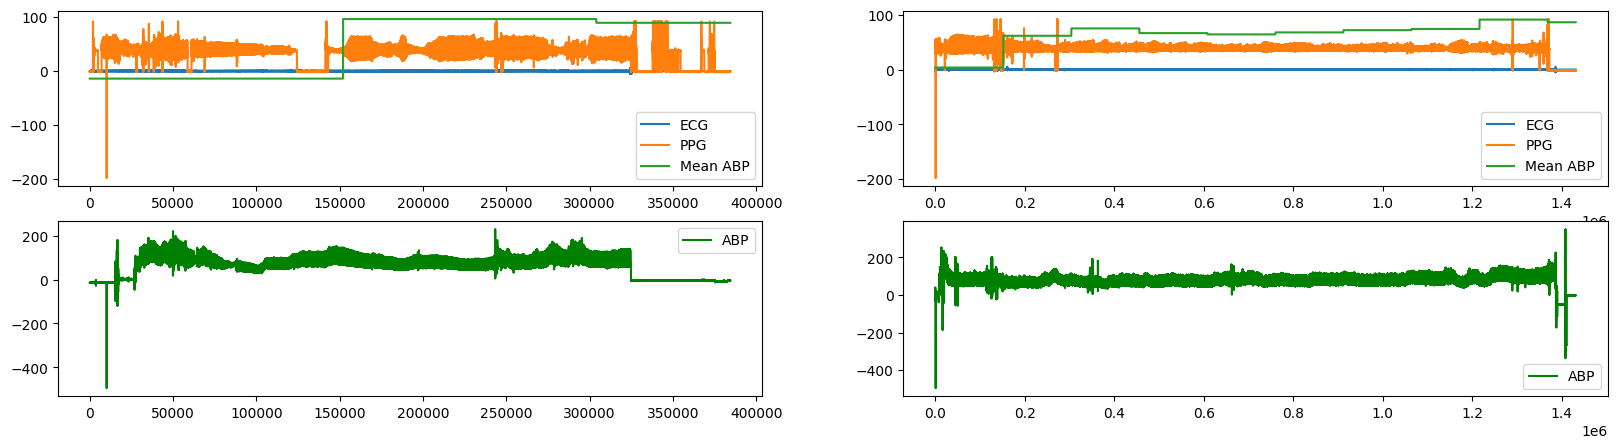

In [14]:
# Plot the sequences when there are more than 1 samples
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))

for i in range(2):
    ax[0, i].plot(X[i][0], label='ECG')
    ax[0, i].plot(X[i][1], label='PPG')
    ax[0, i].plot(X[i][2], label='Mean ABP')
    ax[0, i].legend()

    ax[1, i].plot(y[i].squeeze(), label='ABP', color='green')
    ax[1, i].legend()
    """
    Again, kind of messy figures here. Difficult to tell what's going on.
    Consider using the zoomed in view like in the above figure. Also while we
    are taking the mean of windows of ABP, is it entirely accurate to 
    call that Mean ABP? Maybe downsampled ABP is more clear. Or consider
    labeling it as approximate blood pressure cuff. Something to make it clear
    that we have altered that data to be the mean of a window rather than the 
    mean of the entire dataset.
    """
plt.show()

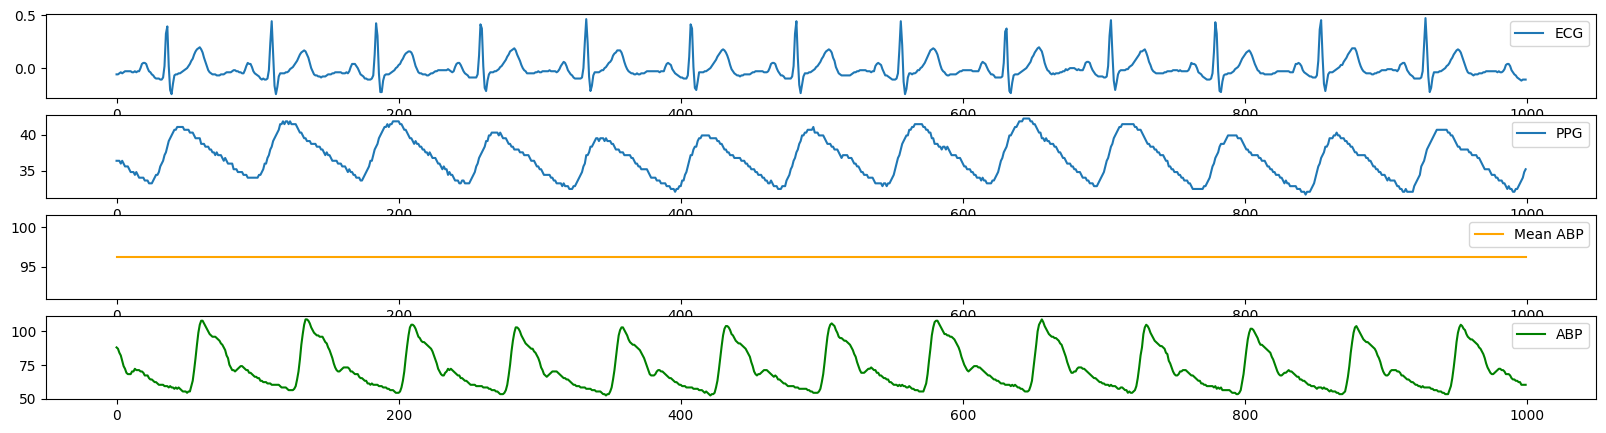

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 5))

ax[0].plot(X[0][0][200000:201000], label='ECG')
ax[0].legend()
ax[1].plot(X[0][1][200000:201000], label='PPG')
ax[1].legend()
ax[2].plot(X[0][2][200000:201000], label='Mean ABP', color='orange')
ax[2].legend()

ax[3].plot(y[0].squeeze()[200000:201000], label='ABP', color='green')
ax[3].legend()

plt.show()
"""
This fig below lacks a commented explanation like the others have. It appears to be
a zoomed in view of the above. I would format this like in fig 2. Use a for loop
to make a column for each sample plot mean ABP on the same (large and clear) graph
as ECG and PPG to indicate to the viewer that we are trying to establish a relationship
between the three of them. I'm not sure without a clear label, but I assume that is
the goal of this section. Drive home to a potential viewer that we can relate
these pieces of data with a neat visual. Also, it is now abundantly clear from 
these figures that we are not capturing the peaks and valleys of real-time ABP 
in our downsampling technique. However, this may not be a problem because a BP 
cuff wouldnt do that either which is what we're trying to replicate. This is 
another question I'd like to run by medical. With my non medical training, I assume
that the flatline of mean ABP will not be very useful.

Now that I've looked over all of these figures I assume they are included bc:
1) we want to be certain that the data looks like ie does the ECG looks like 
    an appropirate ECG wave
2) serve as a visual that helps the viewer accept our premise that we can use
    the relationship between these data to reconstruct ABP.
I think these would be best accomplished with just this last figure and a 
randomized 1000 unit frame rather than a hard coded frame and four unclear
figures.
"""

In [16]:

# Define segmentation parameters
"""
See comment up top about config parameters. It may be possible to rig it so we have
complete cardiac cycle per window. Maybe pull in heart rate data as well to do
this. Window and step dynamically determined by pulse. Also, consier building
a function to handle segmentation process.
"""
window_size = 4000
step = 3000 #8000

# Segment input and target sequences
X_segments = []
y_segments = []
for i in range(len(y)):
    X_sample = X[i]
    y_sample = y[i]
    #for j in range(0, X_sample.shape[1]-window_size+1): # Use this for full length sequence
    for j in range(0, 175000):
    """
    Instead of hardcoding 175000, this should be dynamic based on size of X[i]
    Let's try validation function. The if statement is cumbersome.
    """
        X_window = X_sample[:, j:j+window_size]
        # Check if there are constant values in the first array
        y_window = y_sample[j:j+window_size]
        if (np.all(X_window[0] == X_window[0][0])) or (np.any(X_window[0] < -1.5)) or (np.any(X_window[1] > 100)) or (np.any(X_window[1] < 0)) or (np.any(X_window[2] > 200)) or (np.any(X_window[2] < 20)) or (np.all(y_window == y_window[0])) or (np.any(y_window > 200)) or (np.any(y_window < 20)):
          pass
        else:
          # Pad sequences
          if X_window.shape[1] < window_size:
            pad_len = window_size - X_window.shape[1]
            X_window = np.pad(X_window, ((0, 0), (0, pad_len)), mode='constant')
            y_window = np.pad(y_window, (0, pad_len), mode='constant')
          X_segments.append(X_window)
          y_segments.append(y_window)
          del  X_window, y_window

del X_sample, y_sample, X,y

# Convert X_segments to a tensor
#X_segments = tf.convert_to_tensor(X_segments, dtype=tf.float32)
#y_segments = tf.convert_to_tensor(y_segments, dtype=tf.float32).numpy()
"""
Why not use a tensor here?
"""
X_segments = np.asarray(X_segments)
y_segments = np.asarray(y_segments)

# Print shapes of padded and reshaped sequences
print("X_segments shape:", X_segments.shape)
print("y_segments shape:", y_segments.shape)

X_segments shape: (46002, 3, 4000)
y_segments shape: (46002, 4000)


In [13]:
type(X_segments)

numpy.ndarray

In [ ]:
"""
Consider using function approach for data splitting. That way test size etc in config file.
"""
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_segments, y_segments, test_size=0.2, random_state=42, shuffle=True)
del X_segments, y_segments
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)
print(len(X_train),  len(X_test), len(y_train),  len(y_test), len(X_val),len(y_val))

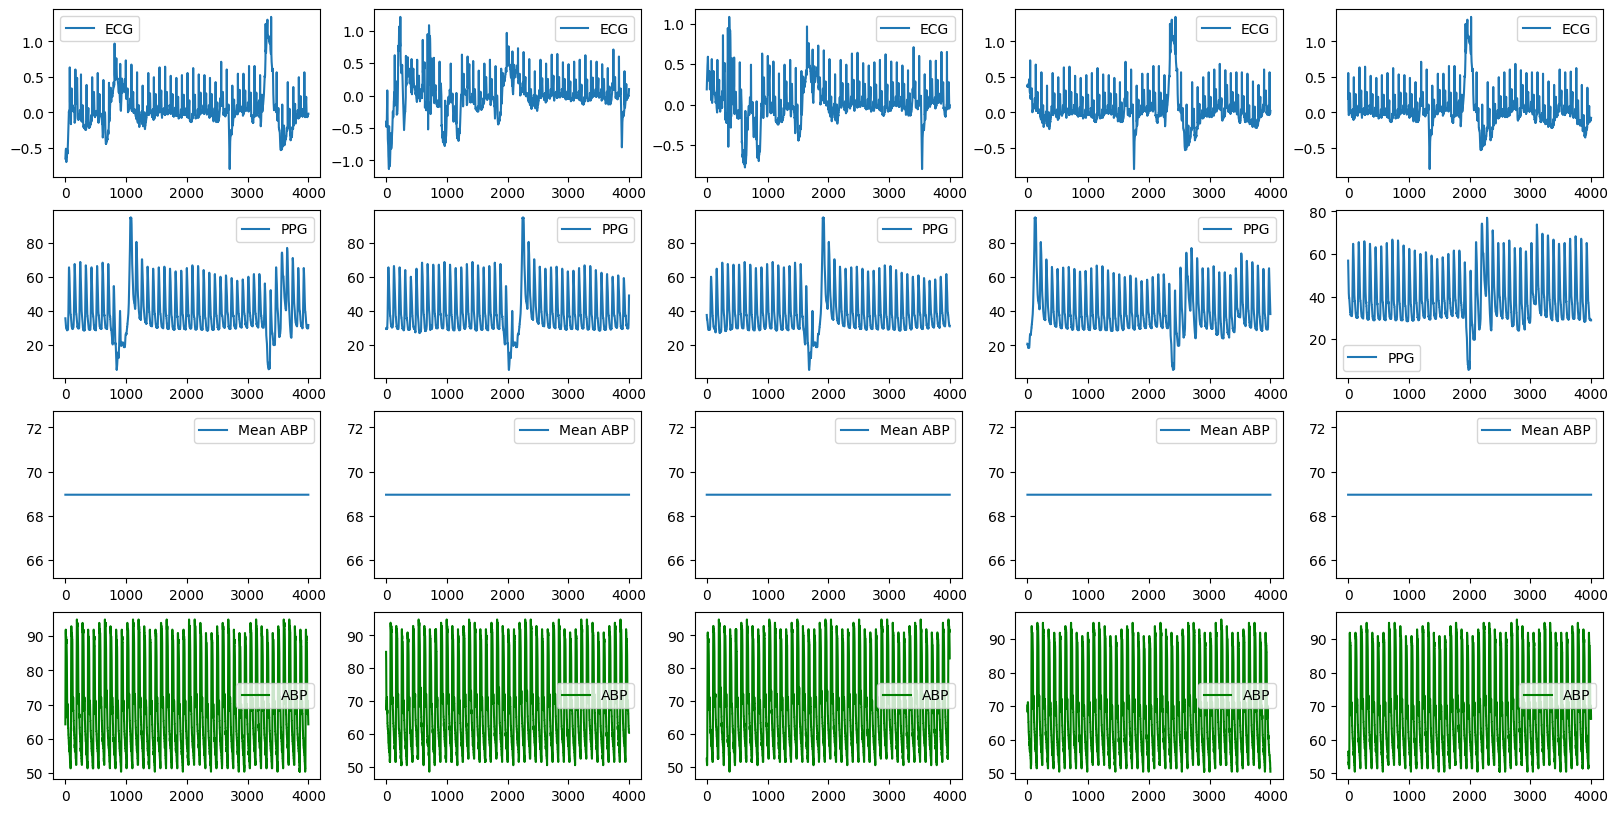

In [12]:
# Plot the sequences
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 10))

for i in range(5):
    ax[0, i].plot(X_test[i, 0], label='ECG')
    ax[0, i].legend()
    ax[1, i].plot(X_test[i, 1], label='PPG')
    ax[1, i].legend()
    ax[2, i].plot(X_test[i, 2], label='Mean ABP')
    ax[2, i].legend()

    ax[3, i].plot(y_test[i].squeeze(), label='ABP', color='green')
    ax[3, i].legend()

plt.show()
"""
Consider adding mean ABP as line on full ABP in contrasting color. And as
before, consider adding more information to these graphs.
"""

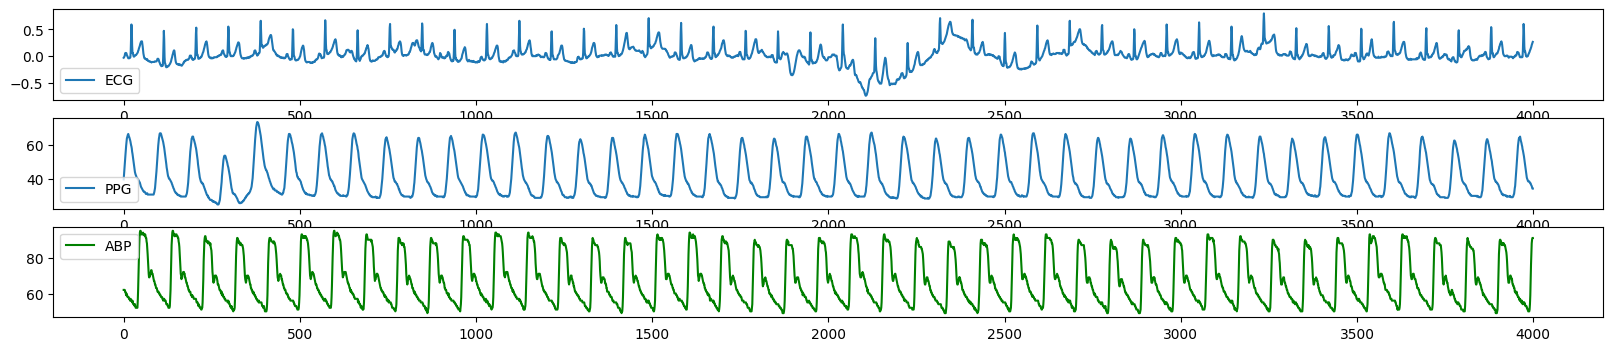

In [13]:
# Plot the sequences
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 4))
i=100
ax[0].plot(X_test[ i][0], label='ECG')
ax[0].legend()
ax[1].plot(X_test[ i][1], label='PPG')
ax[1].legend()

ax[2].plot(y_test[i].squeeze(), label='ABP', color='green')
ax[2].legend()

plt.show()
"""
Kind of like I mentioned before, to me having one very clear example chosen 
at random is best if we really do want this for illustration purposes. So I would
include only the following figure and choose the window at random.
"""

In [17]:
y_train.shape

(8769, 4000)

In [18]:
X_train.shape

(8769, 3, 4000)

In [19]:
X_train.shape[2]

4000

In [20]:
np.isnan(X_train).any()
"""
We already cleaned up nan before, but this could also be something we handle in the segmentation function.
"""

False

In [ ]:
#del model

In [14]:
"""
Why LSTM? This is the method found to be most effective in the paper, but it is worth experimenting.
"""
try:
  # Create the TPU cluster resolver
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)

  # Create the distributed strategy
  strategy = tf.distribute.TPUStrategy(tpu)

  # Define the model architecture
  with strategy.scope():
      model = models.Sequential([
    layers.Input(shape=(3, X_train.shape[2])),
    layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   kernel_regularizer=regularizers.l2(0.01)),
    #layers.TimeDistributed(layers.Dense(64, activation='relu')), #use this if you want to predict for each time step
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(X_train.shape[2], activation='linear')
])
      #model.add(layers.Flatten())
      model.compile(optimizer=optimizers.Adam(clipnorm=1.0), loss='mse')
except:
  with tf.device('/device:GPU:0'):  # set the device to be the first GPU
    model = models.Sequential([
    layers.Input(shape=(3, X_train.shape[2])),
    layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   kernel_regularizer=regularizers.l2(0.01)),
    #layers.TimeDistributed(layers.Dense(64, activation='relu')), #use this if you want to predict for each time step
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(X_train.shape[2], activation='linear')
])
      #model.add(layers.Flatten())
    model.compile(optimizer=optimizers.Adam(clipnorm=1.0), loss='mse')


model.summary()
# Train the model
"""
consider using training function. That would also make it easier to modulate things like
stopping rate or callbacks rather than hard coding them in.
"""
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
history = model.fit(X_train, y_train, epochs=100, steps_per_epoch=len(X_train)//64, batch_size=64,
                    validation_data=(X_val, y_val), validation_steps=len(X_val)//64,
                    callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             1040640   
                                                                 
 dense (Dense)               (None, 3, 64)             4160      
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 4000)              772000    
                                                                 
Total params: 1,816,800
Trainable params: 1,816,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
110/110 [=========================

In [15]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate overall accuracy between target and predicted sequences
# assuming y_pred has shape (4483, 2000, 1)
#y_pred_squeezed = tf.squeeze(y_pred, axis=-1)
"""
We can remove these lines. 
"""

# compute the overall accuracy
overall_accuracy = 1 - tf.reduce_mean(tf.abs(y_pred - y_test) / y_test)
test_loss = model.evaluate(X_test, y_test)

print('Test loss:', test_loss)
#print('Test accuracy:', test_accuracy)
print('Overall accuracy:', overall_accuracy.numpy())

RMSE = math.sqrt(mean_squared_error(y_test, y_pred))

print("Root Mean Square Error:", RMSE)

69/69 [==============================] - 2s 14ms/step - loss: 50.3020
Test loss: 50.30200958251953
Overall accuracy: 0.9293806439990625
Root Mean Square Error: 6.629989928182272


In [16]:
# Define the function to return the MAPE values
"""
Excellent inclusion of function here. Would like to see entire code refactored
this way.
"""
def calculate_mape(actual, predicted) -> float:

    # Convert actual and predicted
    # to numpy array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)

    # Calculate the MAPE value and return
    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

# Get MAPE for python list as parameters
print("MAPE :",
          calculate_mape(y_test,
                         y_pred), "%")
"""
Consider including seperate diastolic and systolic error metric. It's 
honestly a little bit baffling that we are reporting such low error with
only the mean ABP on a given window.
"""

MAPE : 7.06 %


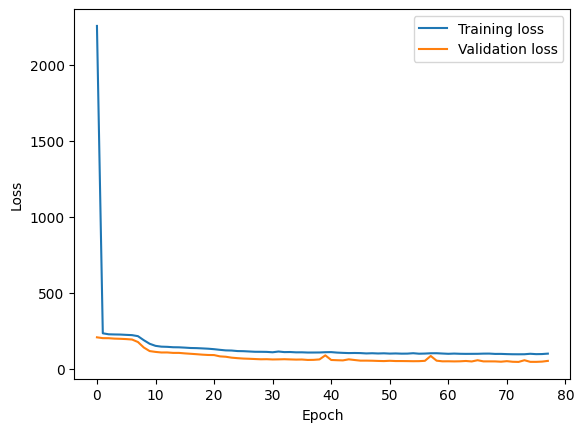

In [17]:
# Plot the training and validation loss
"""
See earlier comments abt plotting function.
Original paper includes Bland-Altman showing deviation of prediction
from observed probe data.
"""
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
X_test.shape[0]

7895

In [ ]:
y_test.shape[0]

7895

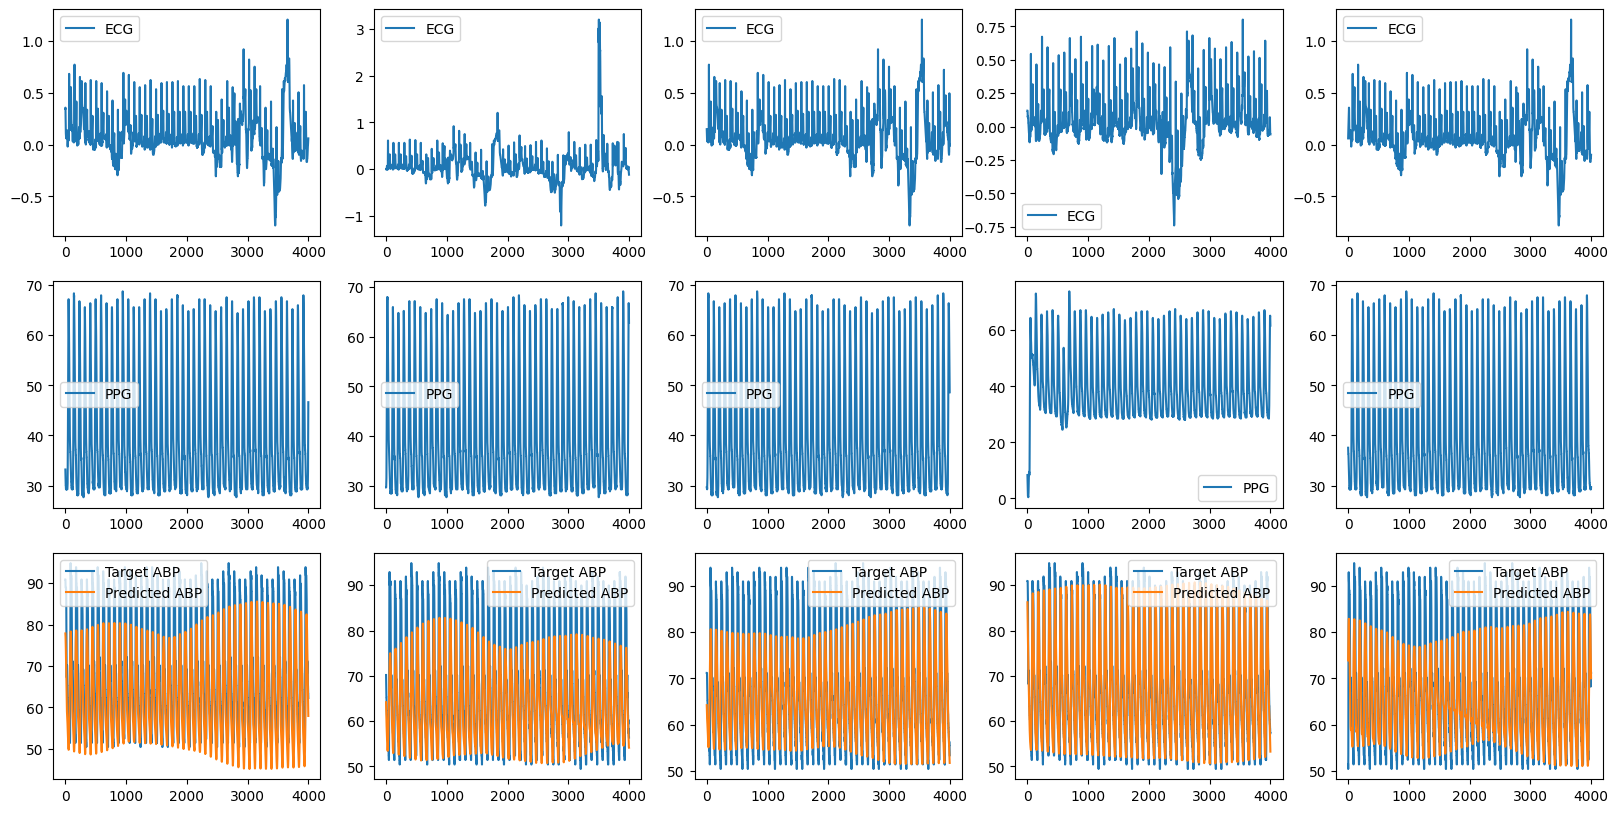

In [18]:
# Plot the sequences
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))
j=0
for i in [np.random.randint(0, X_test.shape[0]) for i in range(0,5)]:
    ax[0, j].plot(X_test[i, 0], label='ECG')
    ax[1, j].plot(X_test[i, 1], label='PPG')
    ax[0, j].legend()
    ax[1, j].legend()

    ax[2, j].plot(y_test[i].squeeze(), label='Target ABP')
    ax[2, j].plot(y_pred[i].squeeze(), label='Predicted ABP')
    ax[2, j].legend()
    j=j+1

plt.show()


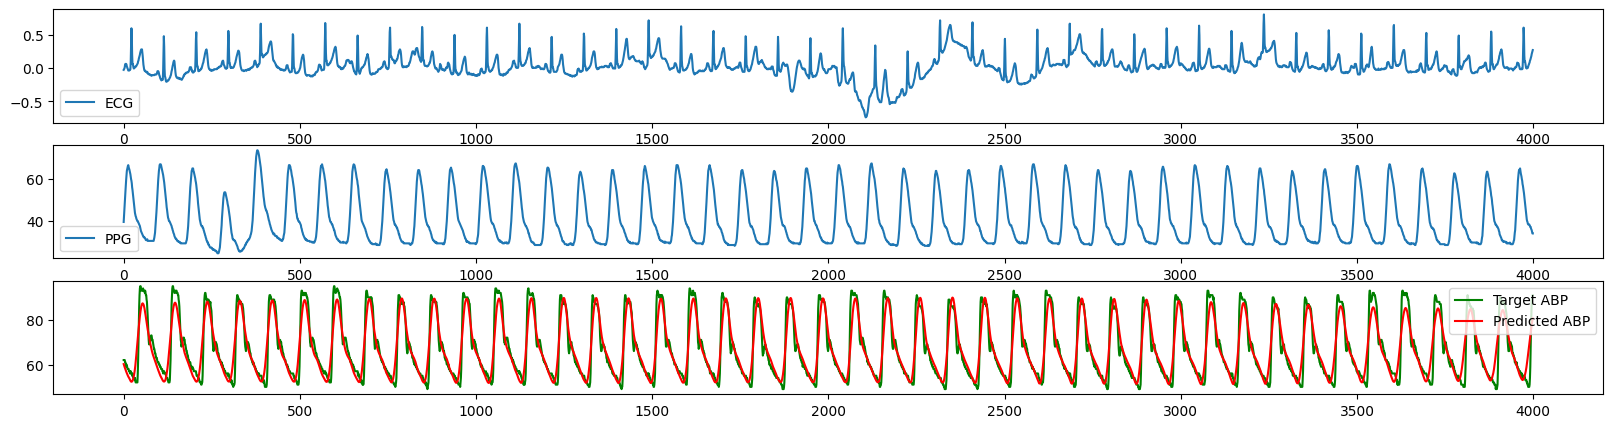

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
i=100
#for i in [np.random.randint(0, X_test.shape[0]) for i in range(0,5)]:
ax[0].plot(X_test[i][0], label='ECG')
ax[1].plot(X_test[i][1], label='PPG')
ax[0].legend()
ax[1].legend()

ax[2].plot(y_test[i].squeeze(), label='Target ABP', color='green')
ax[2].plot(y_pred[i].squeeze(), label='Predicted ABP', color='red')
ax[2].legend()

plt.show()

In [ ]:
#The End
"""
Excellent job! To make this code the best that it can be there are a few things
we need to clean up.
1. OOP - we can organize this into a series of callable functions with a config file up top
2. Save model at end and save (clean, labeled) figures
3. generate a nice report at the end abt performance and accuracy as well as comment the code thoroughly

Then once we ahve those there are some things that would be nice to have that would prob boost the
code to the next level.
1. Improve downsampling by bringing in systolic (max), diastolic (min), and heart rate on a cardiac cycle
like what is used in the paper.
2. The paper also uses a much much larger sample size of ~200 patients. This may not be feasible for us,
but we can certainly attempt more than 2. 
3. The paper also includes Bland-Altman plots as an accuracy metric. Let's include those here.
"""